# Analysis of clustering using dbscan

In [71]:
import numpy as np
import matplotlib as mpl; import matplotlib.pyplot as plt
%matplotlib inline
import os; import pickle
from sklearn import cluster, datasets
import matplotlib.cm as cm

From Wikipedia:

"**DBSCAN = Density-based spatial clustering of applications with noise** is a data clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions. DBSCAn is one of the most common clustering algorithms and also most cited in scientific literature ..."

" Every data mining task has the problem of parameters. Every parameter influences the algorithm in specific ways. For DBSCAN, the parameters $\epsilon$ and minPts are needed ..."

From *scikit-learn.org:*



The values for $\epsilon$ and min_samples used by Scheer were:

$\epsilon=0.075$

min_samples = 1

**"Good for data which contains clusters of similar density."**

In [91]:
np.random.seed(0)

In [92]:
X, y=datasets.make_blobs(1000,2,10);

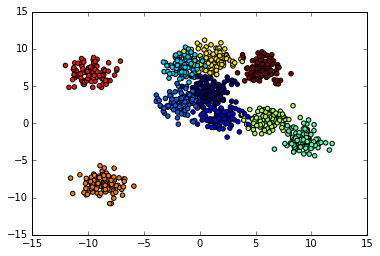

In [93]:
plt.figure()
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

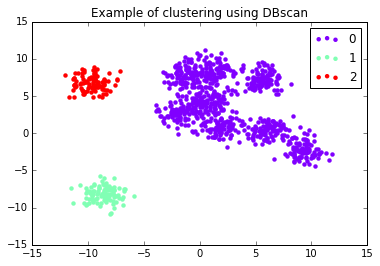

In [101]:
clustering=cluster.DBSCAN(eps=2.5,min_samples = 10)
clustering.fit(X)
sets_of_labels=np.unique(clustering.labels_)
plt.figure()
predicted_groups=clustering.fit_predict(X)
colors = cm.rainbow(np.linspace(0,1,len(sets_of_labels)))
for label, color in zip(sets_of_labels, colors):
    this_X = X[predicted_groups == label]
    plt.scatter(this_X[:,0], this_X[:,1],lw=0,label=label,c=color)
plt.legend()
plt.title('Example of clustering using DBscan')
plt.show()
#clustering.fit_predict(np.random.uniform(-15,10,(100,2)))

In [ ]:
# %load analysis.py
# NV-spin-tomography Michael Scheer mgscheer@gmail.com

# the main code for the analysis

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize as opt
from scipy import special, fftpack, signal
import operator, heapq, itertools, warnings
import sklearn as sk
import learning

# frequency scale -- turns kHz into radial Hz. Used for printing paramaters nicely
mag = 2 * np.pi * 1e3

# a special error class that is thrown in this code when a fit does not work
class FitError(Exception):
	def __init__(self, value):
		self.value = value
	def __str__(self):
		return repr(self.value)

# create a nice looking plot
def initialize_data_plot(figsize = (10,5), xlims = None, ylims = [-1.05,1.05]):
	fig,ax = plt.subplots(figsize=figsize)
	ax.set_ylim(ylims)
	if xlims is not None:
		ax.set_xlim(xlims)
	return fig, ax

# calculates the M function for a single spin A, B
def calc_M_single(A,B,N,omega_larmor,tau):
	tau = np.array(tau)
	omega_tilde = np.sqrt((A + omega_larmor) ** 2 + B ** 2)
	mx = B/omega_tilde
	mz = (A+omega_larmor)/omega_tilde
	alpha = omega_tilde * tau
	beta = omega_larmor * tau
	cos_phi = np.cos(alpha) * np.cos(beta)- mz * np.sin(alpha) * np.sin(beta)
	vec_num = (mx ** 2) * (1-np.cos(alpha)) * (1-np.cos(beta))
	vec_denom = 1.0 + cos_phi
	for i in np.where(vec_denom == 0.0)[0]:
		vec_denom[i] = .0001
	vec_term = vec_num/vec_denom
	angle_term = np.sin(N * np.arccos(cos_phi) / 2.0) ** 2
	return 1 - (vec_term * angle_term)

# calculates the M function corresponding to many spins given by
# A_list, B_list
# equivalent to np.array([calc_M_single(A, B, N, omega_larmor, tau) for A, B in zip(A_list, B_list)]).prod()
def calc_M(A_list, B_list, N, omega_larmor, tau):
	'''
	calc_M(A_list, B_list, N, omega_larmor, tau)
	gives back M
	'''
	return reduce(lambda accum, next: accum * calc_M_single(next[0], next[1], N, omega_larmor, tau), zip(A_list, B_list), 1.0)

# calculates what A and B must be given the value of cos(phi) as well as omega_tilde
def calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde):
	alpha = omega_tilde * res_tau
	beta = omega_larmor * res_tau
	mz = (np.cos(alpha) * np.cos(beta) - cosphi)/(np.sin(alpha) * np.sin(beta))
	A = mz * omega_tilde - omega_larmor
	B = np.sqrt((1 - mz ** 2)) * omega_tilde
	return A, np.abs(B)

# Firm bounds on omega_tilde arising from an upper bound on hyperfine couplings
def omega_bounds(omega_larmor, coupling_bound = 150 * mag):
	upper_omega_bound = omega_larmor + coupling_bound
	lower_omega_bound = omega_larmor - coupling_bound
	return lower_omega_bound, upper_omega_bound

# checks if the A, B pair has a coupling larger than coupling_bound
def valid_A_B(A, B, coupling_bound = 150 * mag):
	return A ** 2 + B ** 2 <= coupling_bound ** 2

# for a real sequence y indexed by a sequence x,
# writes y = a0 + a1 * cos(omega_0 * x) + b1 * sin(omega_0 * x) + ...
# with omega_0 = 2 * np.pi/len(x)
# as a "fourier series" (though for discrete y not continuous) and finds (very approximately)
# the a and b coefficients.
# coefs.real = a0, a1, a2, ...
# coefs.imag = 0, -b1, -b2, ... (notice the negative signs)
# see http://www.feynmanlectures.caltech.edu/I_50.html for fourier series and
# http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.fftpack.fft.html for the formula used for FFT.
# notice the 2/N difference between the two formulas for all but the 0 frequency term.
def sinusoid_coefs_fft(x, y):
	ft = fftpack.fft(y)
	freqs = fftpack.fftfreq(len(x), d = (x[1]-x[0])/(2*np.pi))
	# get rid of negative frequencies
	ft, freqs = map(np.array, zip(*filter(lambda p: p[1] >= 0, zip(ft, freqs))))
	coefs = 2.0 * np.array(ft)/len(x)
	coefs[0] = .5 * coefs[0]
	return coefs, freqs

# given the coefs and freqs from sinusoid_coefs_fft, finds the most likely frequencies
# present in the signal. It looks for peaks in both the real and imaginary part of the coefficients.
# it returns a list of frequencies in decreasing order of likelihood, based on the absolute value of the
# fourier spectrum (coefs) at that point.
def find_peaks_from_fourier(coefs, freqs):
	extremal_inds = signal.argrelextrema(coefs.real, np.greater)[0]
	extremal_inds = np.r_[extremal_inds, signal.argrelextrema(coefs.real, np.less)[0]]
	extremal_inds = np.r_[extremal_inds, signal.argrelextrema(coefs.imag, np.greater)[0]]
	extremal_inds = np.r_[extremal_inds, signal.argrelextrema(coefs.imag, np.less)[0]]
	extremal_inds = np.unique(extremal_inds)
	freq_inds = sorted(extremal_inds, key=lambda ind: -np.abs(coefs[ind]))
	return freqs[freq_inds]

# takes a list of frequencies that are peaks in a fourier spectrum, either of the real
# or imaginary part as well as a number of spins to look for. It then approximates the frequencies
# of the underlying product cosine functions that were in the signal. See appendix C of thesis.
def gen_freqs_from_fourier(freqs, num_spins):
	# sort them in decreasing order
	freqs = sorted(freqs, key=lambda x:-x)
	if num_spins == 1: # requires 1 freq
		return [freqs[0]]
	elif num_spins == 2: # requires 2 freqs
		f0, f1 = freqs[:2]
		return [.5 * (f0 + f1), .5 * (f0 - f1)]
	elif num_spins == 3: # requires 3 freqs
		f0, f1, f2 = freqs[:3]
		return [.5 * (f1 + f2), .5 * (f0 - f2), .5 * (f0 - f1)]
	elif num_spins == 4: # requires 5 freqs
		phi01sum, phi2, phi3 = gen_freqs_from_fourier(freqs[:4], 3)
		f3, f4 = freqs[3:5]        
		phi0 = .5 * (f3 + f4)
		phi1 = phi01sum - phi0
		return [phi0, phi1, phi2, phi3]
	else:
		return gen_freqs_from_fourier(freqs, 4) # change this if you figure out how to do 5

# the form of the signal as a function of N for a fixed tau
def spin_fit_fun_single(N, phi, x):
	return 1 - x * (np.sin(N * phi/2.0) ** 2)

# the form of the signal as a function of N for a fixed tau with several spins
# there can be any number of spins passed, in the form [phi0, phi1, ..., phin, x0, x1, ..., xn]
# where the function for a single spin is 1 - x * (np.sin(N * phi/2.0) ** 2)
# equivalent to np.array([single_spin_fit_fun(N, phi, x) for phi, x in zip(phis, xs)]).prod()
def spin_fit_fun(N, *args):
	num_spins = len(args)/2
	phis, xs = args[:num_spins], args[num_spins:2*num_spins]
	return reduce(lambda accum, next: accum * spin_fit_fun_single(N, next[0], next[1]), zip(phis, xs), 1.0)

# for two arrays l1 and l2 returns the squared error between them
def squared_error(l1, l2):
	return sum((l1 - l2) ** 2)

# Use scipy.optimize.curve_fit to fit N_data to several spins using fit_fun. Requires a guess of the spin
# parameters (phi's and x's) as param_guess
def spin_fit_guess(N_vals, N_data, num_spins, param_guess, error_fun = squared_error, fit_fun = spin_fit_fun):
	try:
		with warnings.catch_warnings():
			warnings.simplefilter("ignore")
			popts, pcovs = opt.curve_fit(fit_fun, N_vals, N_data, p0 = param_guess)
		xs = popts[num_spins:2*num_spins]
		error = error_fun(fit_fun(N_vals, *popts), N_data)
		return popts, error, np.all((xs > 0) & (xs <= 2))
	except (RuntimeError, TypeError):
		raise FitError("Failed to fit spins with N data.")

# fit possibly several spins using a fit_fun to N_data
# for reference, see http://stackoverflow.com/questions/13405053/scipy-leastsq-fit-to-a-sine-wave-failing
# and appendix C of thesis.
def spin_fit(N_vals, N_data, error_fun = squared_error, verbose = True, plots = True, fit_fun = spin_fit_fun, extra_params = []):
	coefs, freqs = sinusoid_coefs_fft(N_vals, N_data)
	likely_freqs = find_peaks_from_fourier(coefs, freqs)
	params, errors, spins_found = [], [], []
	# the higest number of spins that can be fit with l frequencies
	def highest_spin(l):
		if l <= 3:
			return l
		elif l == 4:
			return 3
		else:
			return 4 # make this 5 if you figure out how to do 5
	for num_spins in range(1,1 + highest_spin(len(likely_freqs))):
		approx_phis = gen_freqs_from_fourier(likely_freqs, num_spins)
		approx_xs = num_spins * [2.0]
		p0s = approx_phis + approx_xs + extra_params[:num_spins]
		try:
			popts, error, valid = spin_fit_guess(N_vals, N_data, num_spins, p0s, error_fun = error_fun, fit_fun = fit_fun)
			if valid:
				params.append(popts)
				errors.append(error)
				spins_found.append(num_spins)
		except FitError:
			pass
	if not params:
		raise FitError("Failed to fit spins with N data.")
	else:
		ind = np.argmin(errors)
		if plots:
			plt.figure(figsize=(10,10))
			plt.plot(freqs, coefs.real, label = 'real part')
			plt.plot(freqs, coefs.imag, label = 'imag part')
			plt.title('Fourier spectrum')
			plt.xlabel('phi')
			plt.ylabel('Fourier coeficient')
			plt.legend()
			plt.show()
			plt.figure(figsize=(10,10))
			plt.plot(N_vals, N_data, '.-k', lw=0.4, label = 'data')
			plt.plot(N_vals, fit_fun(N_vals, *params[ind]), label = 'fit')
			plt.title('Fitted N data')
			plt.xlabel('N')
			plt.ylabel('M')
			plt.legend()
			plt.show()
		return params[ind], spins_found[ind]

# repeated attempts to fit N_vals and N_data using several spins. It tries subsets of the data of increasing length
# and then uses the best result as a guess for one final fit of the whole data. See appendix C of thesis for more detail.
def repeated_spin_fit(N_vals, N_data, error_tol, error_fun = squared_error, num_subsets = 4,
	fit_fun = spin_fit_fun, extra_params = [], verbose = True, plots = True):
	spin_fits, scaled_errors = [], []
	for subset in [np.arange(int(len(N_vals) * r)) for r in np.linspace(0, 1, 1 + num_subsets)[1:]]:
		try:
			spin_ans = spin_fit(N_vals[subset], N_data[subset], error_fun = error_fun, fit_fun = fit_fun,
				extra_params = extra_params, verbose = verbose, plots = plots)
			spin_fits.append(spin_ans)
			scaled_errors.append(1.0 * error_fun(fit_fun(N_vals, *spin_ans[0]), N_data)/len(N_vals))
		except FitError:
			pass
	if not spin_fits:
		raise FitError("Failed to fit spins with N data.")
	min_ind = np.argmin(scaled_errors)
	popt_spin, num_spins = spin_fits[min_ind]
	if verbose:
		print "best before final pass: ", min_ind
		phis, xs = np.array(popt_spin[:num_spins]) % np.pi, np.array(popt_spin[num_spins:2*num_spins])
		phis, xs = map(np.array, zip(*sorted(zip(phis, xs), key = lambda x:-x[1])))# sort phis in decreasing order by xs
		print "answer before final pass: ", xs, phis
	try:
		popts, error, valid = spin_fit_guess(N_vals, N_data, num_spins, popt_spin, error_fun = error_fun, fit_fun = fit_fun)
		if valid:
			spin_fits.append((popts, num_spins))
			scaled_errors.append(1.0 * error_fun(fit_fun(N_vals, *popts), N_data)/len(N_vals))
			min_ind = np.argmin(scaled_errors)
			popt_spin, num_spins = spin_fits[min_ind]
		if plots:
			plt.figure(figsize = (10,10))
			plt.plot(N_vals, N_data, '.-k', lw=0.4, label = 'data')
			plt.plot(N_vals, fit_fun(N_vals, *popts), label = 'fit')
			plt.title('Fitted N data')
			plt.xlabel('N')
			plt.ylabel('M')
			plt.legend()
			plt.show()
	except FitError:
		pass
	if verbose:
		print "best overall: ", min_ind
		print scaled_errors
	scaled_error = scaled_errors[min_ind]
	phis, xs = np.array(popt_spin[:num_spins]) % np.pi, np.array(popt_spin[num_spins:2*num_spins])
	#phis, xs = map(np.array, zip(*sorted(zip(phis, xs), key = lambda x:-x[1])))# sort phis in decreasing order by xs
	return phis, xs, scaled_error    

# creates a tau vector that matches the tau from real data from Tim and Julia.
# should be filled in with realistic tau vectors for other N in the future.
def choose_tau_params(N, num_samples = 5100):
	if N != 64:
		raise FitError("N should be 64")
	else:
		min_tau = 3.0000000000000001e-06
		max_tau = 2.1999999999999999e-05
		length = num_samples
		tau = np.linspace(min_tau, max_tau, length)
		return tau

# finds local minima in the vector data as well as the intervals in which they are minima.
# only finds dips below fit_dips_below and less wide than max_width if the parameters are not None.
def find_resonances(data, fit_dips_below = None, max_width = None):
	min_inds = (signal.argrelextrema(data, np.less)[0]).astype(int)
	max_inds = (signal.argrelextrema(data, np.greater)[0]).astype(int)
	widths = max_inds[1:] - max_inds[:-1]
	dip_inds = min_inds[1:] if min_inds[0] < max_inds[0] else min_inds[:-1]
	windows = [(max_inds[i], max_inds[i+1]) for i in range(len(dip_inds)-1)] # should this be 3?
	# a dip must go below fit_dips_below, unless fit_dips_below = None and it's width should be at most max_width unless max_width = None
	filter_fun = lambda p: ((data[p[0]] < fit_dips_below) if (fit_dips_below != None) else True) and (p[1] <= max_width if max_width != None else True)
	dip_inds, widths, windows = map(np.array, zip(*filter(filter_fun, zip(dip_inds, widths, windows))))
	# sort by width
	# sort_inds = np.argsort(-1 * widths)
	# return dip_inds[sort_inds], windows[sort_inds]
	return dip_inds, windows

# Calculates all possible omega_tilde values for a given phi and x at a given res_tau.
# See chapter 4 of thesis.
def calc_omega_tilde(phi, x, res_tau, omega_larmor):
	beta = omega_larmor * res_tau
	cosbeta, cosphi_0 = np.cos(beta), np.cos(phi)
	lower_omega_bound, upper_omega_bound = omega_bounds(omega_larmor)
	omega_cosphi = []
	for cosphi in [cosphi_0, -cosphi_0]:
		prod = x * (1+cosbeta) * (1+cosphi)
		coeff = [1, prod - 2 * cosbeta * cosphi, prod + cosbeta ** 2 + cosphi ** 2 - 1]
		if coeff[1] ** 2 - 4 * coeff[0] * coeff[2] >= 0: # discriminant is nonnegative
			cosalphas = np.roots(coeff)
			for cosalpha in filter(lambda x: np.abs(x) <= 1, cosalphas):
				alpha_0_pi = np.arccos(cosalpha)
				for alpha_base in [alpha_0_pi, 2 * np.pi - alpha_0_pi]:
					lower_int = int(np.ceil((lower_omega_bound * res_tau - alpha_base)/(2 * np.pi)))
					upper_int = int(np.floor((upper_omega_bound * res_tau - alpha_base)/(2 * np.pi)))
					for n in range(lower_int, upper_int + 1):
						omega_cosphi.append(((alpha_base + 2 * np.pi * n)/res_tau, cosphi))
	return omega_cosphi

# for a given dip_ind, measures N data and fits it using repeated_spin_fit. If the fit error is less than error_tol,
# it finds all possible A and B values for each fit spin. Each possible A and B value that is within the bounds (is_valid)
# is added to spin_dict.
def analyze_dip(dip_ind, tau, data_func, omega_larmor, spin_dict = {}, error_tol = .1/64,
				N_vals = np.arange(0,256,2), error_fun = squared_error, fit_fun = spin_fit_fun, extra_params = [],
				num_subsets = 4, verbose = False, plots = False):
	res_tau = tau[dip_ind]
	N_data = data_func(N_vals, res_tau)
	try:
		phis, xs, scaled_error = repeated_spin_fit(N_vals, N_data, error_fun = error_fun, fit_fun = fit_fun, extra_params = extra_params,
			num_subsets = num_subsets, verbose = verbose, plots = plots)
	except FitError:
		if verbose:
			print "Failed to fit spins with N data."
		return spin_dict
	if verbose:
		print "res_tau: ", res_tau
		print "scaled_error <= error_tol: ", scaled_error <= error_tol
		print "scaled_error: ", scaled_error
		phis, xs = map(np.array, zip(*sorted(zip(phis, xs), key = lambda x:-x[1])))# sort phis in decreasing order by xs
		print "xs, phis, scaled_error: ", xs, phis, scaled_error
	if scaled_error > error_tol:
		return spin_dict
	for phi, x in zip(phis, xs):
		for omega_tilde, cosphi in calc_omega_tilde(phi, x, res_tau, omega_larmor): # all the possible omegas with their associated cosphis
			A, B = calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
			if valid_A_B(A, B):
				if (dip_ind, phi, x) in spin_dict:
					spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
				else:
					spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
	return spin_dict

# takes in a dict of the type returned by analyze_dip and for each entry which represents a particular spin found at a particular dip
# it chooses the A, B value that minimizes the error_fun from the tau data. It returns these A and B guesses along with the calculated errors.
def choose_spin_guesses(spin_dict, N, omega_larmor, tau, data, classifier, x_min = 1, error_fun = squared_error):
	guess_As, guess_Bs, dataerrs = [], [], []
	all_guess_As, all_guess_Bs, select_As, select_Bs = [], [], [], []
	for k in spin_dict.keys():
		err = []
		for A, B, _ in spin_dict[k]:
			all_guess_As.append(A)
			all_guess_Bs.append(B)
			err.append(error_fun(calc_M_single(A, B, N, omega_larmor, tau), data))
		min_err_ind = np.argmin(err)
		best_A, best_B, best_cosphi = spin_dict[k][min_err_ind]
		select_As.append(best_A)
		select_Bs.append(best_B)
		best_err = err[min_err_ind]
		_, _, x = k
		features = [best_cosphi, x, best_A, best_B, best_err]
		if classifier(features) and x >= x_min:
			guess_As.append(best_A)
			guess_Bs.append(best_B)
			dataerrs.append(best_err)
	return (np.array(guess_As), np.array(guess_Bs), np.array(dataerrs),
		np.array(all_guess_As), np.array(all_guess_Bs), np.array(select_As), np.array(select_Bs))

# given guesses for As and Bs, clusters these guesses using the DBSCAN algorithm.
# for info about DBSCAN see http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# for info about clustering with sklearn see http://scikit-learn.org/stable/modules/clustering.html#clustering
def cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1):
	X = sk.preprocessing.StandardScaler().fit_transform(zip(guess_As, guess_Bs)) # possibly need to be lists?
	db = sk.cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(X)
	labels = db.labels_
	cluster_As, cluster_Bs, cluster_dataerrs = [], [], []
	for k in np.unique(labels):
		if k >= 0:
			label_inds = np.where(labels == k)[0]
			best_guess = np.argmin(dataerrs[label_inds])
			cluster_As.append(guess_As[label_inds][best_guess])
			cluster_Bs.append(guess_Bs[label_inds][best_guess])
			cluster_dataerrs.append(dataerrs[label_inds][best_guess])
	return np.array(cluster_As), np.array(cluster_Bs), np.array(cluster_dataerrs)

# an approximation of the background due to the weakly coupled spins
#A_background = 4 * mag * (np.random.rand(400) - .5)
#B_background = 2 * mag * (np.random.rand(400))
#background_dict = {"A_background" : A_background, "B_background" : B_background}
#learning.store_obj(background_dict, "background_A_B")
background_dict = learning.load_obj("background_A_B")
A_background, B_background = background_dict["A_background"], background_dict["B_background"]

# given guess_As and guess_Bs, this function considers all ways of removing num_remove spins from the guess list
# it compares all of these possibilities along with not taking anything out in terms of the error from this subset to the data
# the error function considers the spins along with 400 weakly coupled spins which approximates the background.
# it returns the optimal subset as well as a number to remove next time: the same number if a spin was removed, otherwise the number
# considered for removal this time plus one (considering taking several out at the same time)
def remove_spins(guess_As, guess_Bs, N, omega_larmor, tau, data, num_remove = 1, error_fun = squared_error, verbose = False):
	# creates all subsets of s with size between lower and upper
	def subset_size_range(s, lower, upper):
		ans = []
		for i in range(lower, upper+1):
			for j in itertools.combinations(s, i):
				ans.append(j)
		return ans
	guess_As, guess_Bs = np.array(guess_As), np.array(guess_Bs)
	M_background = calc_M(A_background, B_background, N, omega_larmor, tau)
	err, As, Bs = [], [], []
	for subset in subset_size_range(range(len(guess_As)), len(guess_As) - num_remove, len(guess_As) - 1):
		subset = np.array(subset)
		err.append(error_fun(M_background * calc_M(guess_As[subset], guess_Bs[subset], N, omega_larmor, tau), data))
		As.append(guess_As[subset])
		Bs.append(guess_Bs[subset])
	best_ind = np.argmin(err)
	orig_error = error_fun(M_background * calc_M(guess_As, guess_Bs, N, omega_larmor, tau), data)
	if verbose:
		print "new error, old error: ", err[best_ind], orig_error
	if orig_error > err[best_ind]:
		return As[best_ind], Bs[best_ind], num_remove
	else:
		return guess_As, guess_Bs, num_remove + 1

# given a data function data_func(N, tau) that represents a diamond, returns an estimation
# of the hyperfine couplings of many c13s. The function returns, in order
# the final estimation, the total set of estimated parameters, the set remaining after using least squares,
# the set remaining after applying the classifier, and then the set after applying clustering. See chapter 4 of thesis.
def analyze_diamond(data_func, N, omega_larmor, kernel = "rbf", verbose = False, plots = False):
	tau = choose_tau_params(N)
	data = data_func(N, tau)
	dip_inds, windows = find_resonances(data, fit_dips_below = None)
	lower_ind_cutoff = 3220 # corresponds to 15 microseconds
	if verbose:
		print "number of dips to measure: ", sum(dip_inds >= lower_ind_cutoff)
	spin_dict = {}
	for dip_ind in dip_inds:
		if dip_ind >= lower_ind_cutoff: # 15 microseconds and on
			spin_dict = analyze_dip(dip_ind, tau, data_func, omega_larmor, spin_dict, N_vals = np.arange(0,256,2),
				error_tol = .1/64, verbose = verbose, plots = plots)
	# load the classifiers
	guess_scaler = learning.load_obj("classifiers/scaler_svm_" + kernel + "_di3220_29diamonds_cxABe")
	guess_clf = learning.load_obj("classifiers/clf_svm_" + kernel + "_di3220_29diamonds_cxABe")
	def guess_classifier(features):
		return guess_clf.predict(guess_scaler.transform([features]))
	guess_As, guess_Bs, dataerrs, all_guess_As, all_guess_Bs, select_As, select_Bs = choose_spin_guesses(spin_dict, N, omega_larmor, tau, data, guess_classifier, x_min = 1, error_fun = squared_error)
	cluster_As, cluster_Bs, cluster_dataerrs = cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
	As, Bs, num_remove = cluster_As, cluster_Bs, 1
	while num_remove <= 2:
		As, Bs, num_remove = remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = squared_error, verbose=verbose)
	return As, Bs, all_guess_As, all_guess_Bs, select_As, select_Bs, guess_As, guess_Bs, cluster_As, cluster_Bs